# Set the project dir

In [2]:
import sys
import os
from pathlib import Path

# Get the absolute path of the project root
ROOT_DIR = Path(os.getcwd()).parent  # Moves up to FOOTBALLAI_ENDPROJECT

# Add ROOT_DIR to sys.path
sys.path.append(str(ROOT_DIR))

In [3]:
import importlib
import config.paths
importlib.reload(config.paths)  # Forces Python to reload the updated file
from config.paths import paths

print('\n'.join(f'{key}: {value}' for key, value in paths.items()))

HOME: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject
DATA: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data
MODELS: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\Models
UTILS: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\utils


# Install Dependencies

In [7]:
%pip install -q gdown inference-gpu
%pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip uninstall -y supervision && pip install -q supervision>=0.23.0

Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1
Note: you may need to restart the kernel to use updated packages.


# Download few videos

In [3]:
ORIGIN_VIDEO_DIR = paths['DATA'] / 'origin_videos'  # Path where the original videos will be saved
ORIGIN_VIDEO_DIR.mkdir(parents=True, exist_ok=True)  # Make dir 'origin_video'

!gdown -O "{ORIGIN_VIDEO_DIR}/0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "{ORIGIN_VIDEO_DIR}/2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "{ORIGIN_VIDEO_DIR}/08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "{ORIGIN_VIDEO_DIR}/573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "{ORIGIN_VIDEO_DIR}/121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\origin_videos\0bfacc_0.mp4

  0%|          | 0.00/19.9M [00:00<?, ?B/s]
  3%|▎         | 524k/19.9M [00:00<00:05, 3.85MB/s]
 13%|█▎        | 2.62M/19.9M [00:00<00:01, 11.9MB/s]
 26%|██▋       | 5.24M/19.9M [00:00<00:00, 15.3MB/s]
 45%|████▍     | 8.91M/19.9M [00:00<00:00, 22.1MB/s]
 66%|██████▌   | 13.1M/19.9M [00:00<00:00, 28.5MB/s]
 84%|████████▍ | 16.8M/19.9M [00:00<00:00, 27.8MB/s]
100%|██████████| 19.9M/19.9M [00:00<00:00, 24.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\origin_videos\2e57b9_0.mp4

  0%|          | 0.00/21.1M [00:00<?, ?B/s]
  2%|▏         | 524k/21.1M [00:00<00:05, 4.04MB/s]
 12%|█▏        | 2.62M/21.1M [00:00<00:01, 12.0MB/s]
 27%|██▋       | 5.77M/21.1M [00:00<00:00, 15.8MB/s]
 55%|█████▍    | 11.5M/21.1M [00

# Test frame

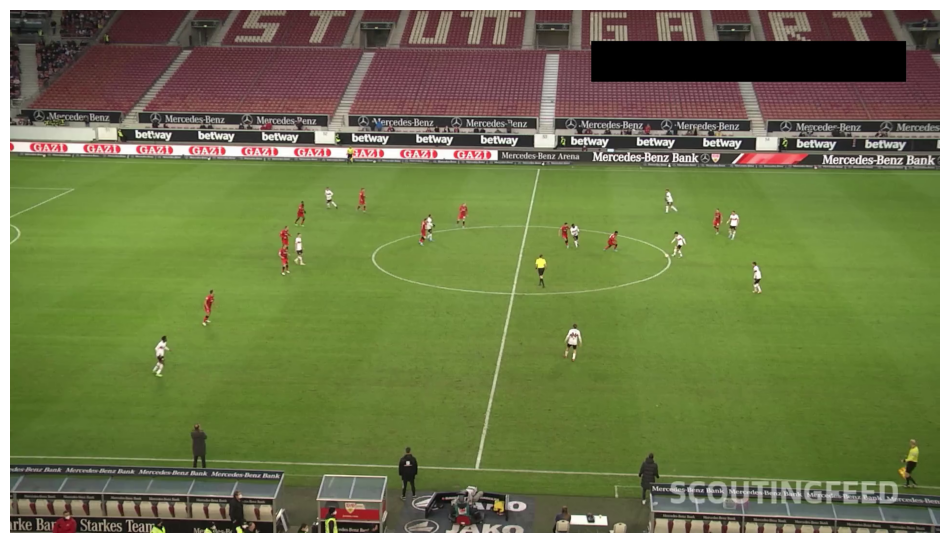

(1080, 1920, 3)

In [4]:
import supervision as sv

ORIGIN_VIDEO_DIR = paths['DATA'] / 'origin_videos'  # Path where the original videos will be saved
ORIGIN_VIDEO_DIR.mkdir(parents=True, exist_ok=True)  # Make dir 'origin_video'
TEST_VIDEO_PATH = ORIGIN_VIDEO_DIR / '0bfacc_0.mp4'

frame_generator = sv.get_video_frames_generator(TEST_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)
frame.shape

# Get the frames from video and split them into images for train, valid and test dirs 

In [23]:
from tqdm import tqdm
import cv2
import os
import shutil
import random

# --------------------------------MAKING IMAGES FROM VIDEOS--------------------------------
def images_from_video(video_paths: list[Path], output_path: Path, start_idx: int=0, stride: int=5):
    '''
    Processes a list of video paths, extracting frames from each video and saving them as images

    Args:
        video_paths (list[Path]): A list of paths to video files. Each path must be a 'Path' object.

        output_path (Path): Path to directory where frames will be saved in .jpg format. Must be a 'Path' object.

        start_idx (int, optional): Starting index for frame numbering. Defaults to 0.

        stride (int): This param is refer to the frequency of downloading frames from video. Defaults to 5.

    Returns:
        None.
    '''

    video_idx = start_idx
    for video_path in video_paths:
        # get the video info to extract total number of frames
        video_info = sv.VideoInfo.from_video_path(str(video_path))
        # Frame generator
        frame_generator = sv.get_video_frames_generator(str(video_path), stride=stride)

        # Process each frame
        current_video = str(video_path).split('\\')[-1]
        for frame in tqdm(frame_generator, total=int(video_info.total_frames / stride), desc=f'Processing {current_video}'):
            target_image_path = output_path / f'image_{video_idx:04d}.jpg'  # Path to save the frame f.g. frame_1234.jpg
            # Save the frame as an image_1234.jpg format
            cv2.imwrite(str(target_image_path), frame)
            video_idx += 1
# --------------------------------MAKING IMAGES FROM VIDEOS--------------------------------

# -------------------------------SPLITTING ALL IMAGES INTO TRAIN, VALID AND TEST DIR-------------------------------
def split_images_into_sets(images_dir: Path, train_ratio: float=0.8, validation_ratio: float=0.1):
    '''
    Splits a set of images located in a specific directory into train, validation and test dirs.

    Args:
        images_dir (Path): The path to the directory containing the images to be split. Mus tbe a 'Path' object.

        train_ratio (float, optional): The ratio of images to be used for the training set. The value should be between 0 and 1, and it 
                    is used to calculate the number of images assigned to the training set. Defaults to 0.8.

        validation_ratio (float, optional): The ratio of images to be used for the validation set. Like the train_ratio, it should be a 
                    value between 0 and 1. The remaining images, after allocating for the training and validation sets, are assigned to the 
                    test set. Defaults to 0.1.
    
    Returns:
        None.
    '''
    # Load the image file names
    images_list = [file for file in os.listdir(str(images_dir)) if file.endswith('.jpg')]
    # Shuffle images
    random.shuffle(images_list)
    
    # Count the number of images in train and valid sets
    total_images = len(images_list)  # number of total images
    train_num = int(total_images * train_ratio)  # number of train images
    valid_num = int(total_images * validation_ratio)  # number of valid images

    # Split the list into train, valid and test sets
    train_images = images_list[:train_num]  # train set
    valid_images = images_list[train_num: train_num + valid_num]  # valid set
    test_images = images_list[train_num + valid_num:]  # test set

    # Paths where images will be splitted into train, valid and test folders
    train_dir = images_dir / 'train'  # path to train folder
    valid_dir = images_dir / 'valid'  # path to validate folder
    test_dir = images_dir / 'test'  # path to test folder
    # Make train, valid and test dir - if doesn't exist
    train_dir.mkdir(parents=True, exist_ok=True)
    valid_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    
    # Move the images to train dir
    for image_file in tqdm(train_images, total=len(train_images), desc='Moving images into train folder'):
        shutil.move(str(images_dir / image_file), str(train_dir / image_file))
    
    # Move images to valid dir
    for image_file in tqdm(valid_images, total=len(valid_images), desc='Moving images into valid folder'):
        shutil.move(str(images_dir / image_file), str(valid_dir / image_file))

    # Move images to test dir
    for image_file in tqdm(test_images, total=len(test_images), desc='Moving images into test folder'):
        shutil.move(str(images_dir / image_file), str(test_dir / image_file))

    print(f'Moved {len(train_images)} to {train_dir}')
    print(f'Moved {len(valid_images)} to {valid_dir}')
    print(f'Moved {len(test_images)} to {test_dir}')
# -------------------------------SPLITTING ALL IMAGES INTO TRAIN, VALID AND TEST DIR-------------------------------

In [24]:
# --------------------------------MAKING IMAGES FROM VIDEOS--------------------------------
ORIGIN_VIDEOS_DIR = paths['DATA'] / 'origin_videos'
IMAGES_DIR = paths['DATA'] / 'images'  # Path where the frames and annotations will be saved
IMAGES_DIR.mkdir(parents=True, exist_ok=True)  # Make dir 'images'

STRIDE = 5  # Get every 5 frame

# List of each video paths
video_paths = [
    ORIGIN_VIDEOS_DIR / video_name 
    for video_name 
    in os.listdir(ORIGIN_VIDEOS_DIR)
]

images_from_video(video_paths, IMAGES_DIR, STRIDE)
# --------------------------------MAKING IMAGES FROM VIDEOS--------------------------------

Processing 573e61_0.mp4: 100%|██████████| 150/150 [00:02<00:00, 56.12it/s]


In [25]:
# -------------------------------SPLITTING ALL IMAGES INTO TRAIN, VALID AND TEST DIR-------------------------------
split_images_into_sets(IMAGES_DIR, train_ratio=0.8, validation_ratio=0.1)
# -------------------------------SPLITTING ALL IMAGES INTO TRAIN, VALID AND TEST DIR-------------------------------

Moving images into test folder: 100%|██████████| 75/75 [00:00<00:00, 1709.13it/s]


Moved 600 to C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\images\train
Moved 75 to C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\images\valid
Moved 75 to C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\images\test


# Image Annotations

## Define pretrained model YOLOv8x

In [5]:
import config.secrets
importlib.reload(config.secrets)  # Forces Python to reload the updated file
from config.secrets import ROBOFLOW_API_KEY
from inference import get_model

# ----------------PRETRAINED YOLOv8x to detect the players on the pitch----------------
PLAYER_DET_MODEL_ID = 'football-players-detection-3zvbc/11'
PLAYER_DET_MODEL = get_model(api_key=ROBOFLOW_API_KEY, model_id=PLAYER_DET_MODEL_ID)
# ----------------PRETRAINED YOLOv8x to detect the players on the pitch----------------

[02/15/25 14:12:51] WARNING  Your inference package version 0.36.1 is out of date! Please upgrade to ]8;id=294486;file://c:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\football_env\lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=444507;file://c:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\football_env\lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.37.1 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

In [6]:
result = PLAYER_DET_MODEL.infer(frame)[0]
detections = sv.Detections.from_inference(result)

The output format of detection in YOLO is YOLO Detections, but the transformer DETR requires COCO format so we need to convert YOLO output to the appropriate format.

In [28]:
detections

Detections(xyxy=array([[1363.,  457., 1397.,  513.],
       [1084.,  504., 1109.,  574.],
       [1478.,  414., 1506.,  476.],
       [ 293.,  672.,  334.,  758.],
       [1141.,  647., 1181.,  728.],
       [1225.,  456., 1256.,  500.],
       [1833.,  886., 1876.,  988.],
       [1351.,  369., 1379.,  421.],
       [ 587.,  394.,  611.,  448.],
       [ 649.,  365.,  677.,  413.],
       [ 715.,  367.,  737.,  419.],
       [1532.,  520., 1553.,  587.],
       [ 586.,  459.,  610.,  528.],
       [1156.,  441., 1176.,  493.],
       [ 397.,  577.,  424.,  653.],
       [ 921.,  399.,  946.,  451.],
       [ 554.,  487.,  579.,  549.],
       [1450.,  410., 1471.,  466.],
       [ 556.,  446.,  582.,  497.],
       [1133.,  438., 1156.,  494.],
       [ 694.,  280.,  710.,  321.],
       [ 844.,  430.,  864.,  488.],
       [ 858.,  422.,  877.,  479.]]), mask=None, confidence=array([0.92940748, 0.92680544, 0.92633474, 0.92558795, 0.92539775,
       0.92404521, 0.92366856, 0.918935  ,

## Converting the output to COCO format

In [37]:
import json
import supervision as sv

# ---------------------------------------------Generator of the image file names---------------------------------------------
def image_generator(images_dir, extension='.jpg'):
    '''
    Generator function that yields image file names from a specified directory.

    Args:
        images_dir (str or Path): The directory containing the image files.

        extension (str, optional): The file extension of the images to be processed. Defaults to '.jpg'.
    
    Yields:
        str: The name of an image file that matches the specified extension.
    '''
    for image_file in os.listdir(images_dir):
        if image_file.endswith(extension):
            yield image_file
# ---------------------------------------------Generator of the image file names---------------------------------------------

# ---------------------------------------------Converting YOLO format to COCO format---------------------------------------------
def yolo_to_coco(yolo_model, images_dir: Path, 
                 output_json: Path, categories: list[dict], 
                 model_confidence_threshold: float=0.3, nms_confidence_threshold: float=0.5):
    '''
    Converts object detections annotations from YOLO format to COCO format and save COCO annotations as an JSON file.

    Args:
        yolo_model: A YOLO model object capable of performing inference on images.
        images_dir (Path): The directory containing images to proess.
        output_json (Path): The path where the output COCO JSON file will be saved.
        categories (list[dict]): A list of category mappings in COCO format, each contating 'id' and 'name'.
        model_confidence_threshold (float, optional): The minimum confidence score for detections to be considered. Defaults to 0.5.
        nms_confidence_threshold (float, optional): The Non-Maximum Suppression (NMS) threshold for removing duplicate detections. Defaults to 0.5.

    Returns:
        None: The function writes the resulting COCO annotations to a JSON file.

    Process:
    1. Initializes a COCO dictionary structure with specified categories.
    2. Iterates over images in the given directory.
    3. Loads each image and stores its metadata (ID, file name, dimensions).
    4. Runs YOLO inference to detect objects in the image.
    5. Applies Non-Maximum Suppression (NMS) to remove duplicate bounding boxes.
    6. Converts YOLO bounding box format (x_min, y_min, x_max, y_max) to COCO format (x_min, y_min, width, height).
    7. Ensures bounding boxes remain within image boundaries.
    8. Saves the processed annotations to a COCO JSON file.
    '''

    # Setting the COCO format
    coco_data = {
        'info': {'year': 2025, 'description': 'Football Player Detection'},
        'images': [],
        'annotations': [],
        'categories': categories
    }

    # bbox counter
    annotation_id = 1
    # Count the number of images in the dir
    num_images = sum(1 for _ in image_generator(images_dir))
    # Processes images
    for image_id, image_file in enumerate(tqdm(image_generator(images_dir), total=num_images, desc=f'Annotating images from: {images_dir}'), start=1):
        img_path = images_dir / image_file  # Absolute path of image
        img = cv2.imread(img_path)  # Read the image
        img_height, img_width, _ = img.shape  # Get the height and width of the image
        
        # Add the image to coco format
        coco_data['images'].append({
            'id': image_id,
            'file_name': image_file,
            'height': img_height,
            'width': img_width
        })

        # YOLO detection
        result = yolo_model.infer(img, confidence=model_confidence_threshold)[0]
        detections = sv.Detections.from_inference(result)
        # Remove duplicate bboxes (NMS)
        detections = detections.with_nms(threshold=nms_confidence_threshold, class_agnostic=True)

        for box, class_id in zip(detections.xyxy, detections.class_id):
            x_min, y_min, x_max, y_max = box.tolist()
            bbox_w, bbox_h = x_max - x_min, y_max - y_min

            # Cut to image shapes
            x_min = max(0, min(x_min, img_width - 1))
            y_min = max(0, min(y_min, img_height - 1))
            bbox_w = max(1, min(bbox_w, img_width - x_min))
            bbox_h = max(1, min(bbox_h, img_height - y_min))

            bbox_coco = [int(x_min), int(y_min), int(bbox_w), int(bbox_h)]

            # Add bbox to COCO
            coco_data['annotations'].append({
                'id': annotation_id,
                'image_id': image_id,
                'category_id': int(class_id) + 1,
                'bbox': bbox_coco,
                'area': round(bbox_w * bbox_h),  # Pole bbox
                'iscrowd': 0
            })
            annotation_id += 1
    
    # Create and write coco_data to JSON file
    with open(output_json, 'w') as f:
        json.dump(coco_data, f, indent=4)

    print(f'Conversion completed! File saved to: {output_json}')
# ---------------------------------------------Converting YOLO format to COCO format---------------------------------------------

In [40]:
# ---------------------------------------------Converting YOLO format to COCO format---------------------------------------------
IMAGES_DIR = paths['DATA'] / 'images'  # Path to the folder containing sets of images
IMAGES_SUBDIRS = ['train', 'valid', 'test']  # Subdirs containing sets of images
COCO_DIR = paths['DATA'] / 'coco_annotations'  # Path to the directory where the output JSON files will be saved
COCO_DIR.mkdir(parents=True, exist_ok=True)  

# Categories which the model predicts
categories = [
    {'id':1, 'name': 'ball'},
    {'id':2, 'name': 'goalkeeper'},
    {'id':3, 'name': 'player'},
    {'id':4, 'name': 'referee'}
]

# Get through the train, valid and test dirs
for image_subdir in IMAGES_SUBDIRS:
    # Absolute path of the current dir
    current_image_dir_path = IMAGES_DIR / image_subdir
    # The path where the coco file will be saved
    current_coco_path = COCO_DIR / f'{image_subdir}.json'
    # Convert the YOLO format to COCO format
    yolo_to_coco(PLAYER_DET_MODEL, 
                 current_image_dir_path, current_coco_path, categories, 
                 model_confidence_threshold=0.3, nms_confidence_threshold=0.5)
# ---------------------------------------------Converting YOLO format to COCO format---------------------------------------------

Annotating images from: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\images\train: 100%|██████████| 898/898 [1:02:10<00:00,  4.15s/it]


Conversion completed! File saved to: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\coco_annotations\train.json


Annotating images from: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\images\valid: 100%|██████████| 124/124 [08:24<00:00,  4.07s/it]


Conversion completed! File saved to: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\coco_annotations\valid.json


Annotating images from: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\images\test: 100%|██████████| 100/100 [06:44<00:00,  4.05s/it]


Conversion completed! File saved to: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\coco_annotations\test.json


## Check annotations from JSON file

Image id: 6
Image file name: 4b770a_1_4_png.rf.8a0f6be9776a652d40938181f60b3a6c.jpg
<class 'numpy.ndarray'>


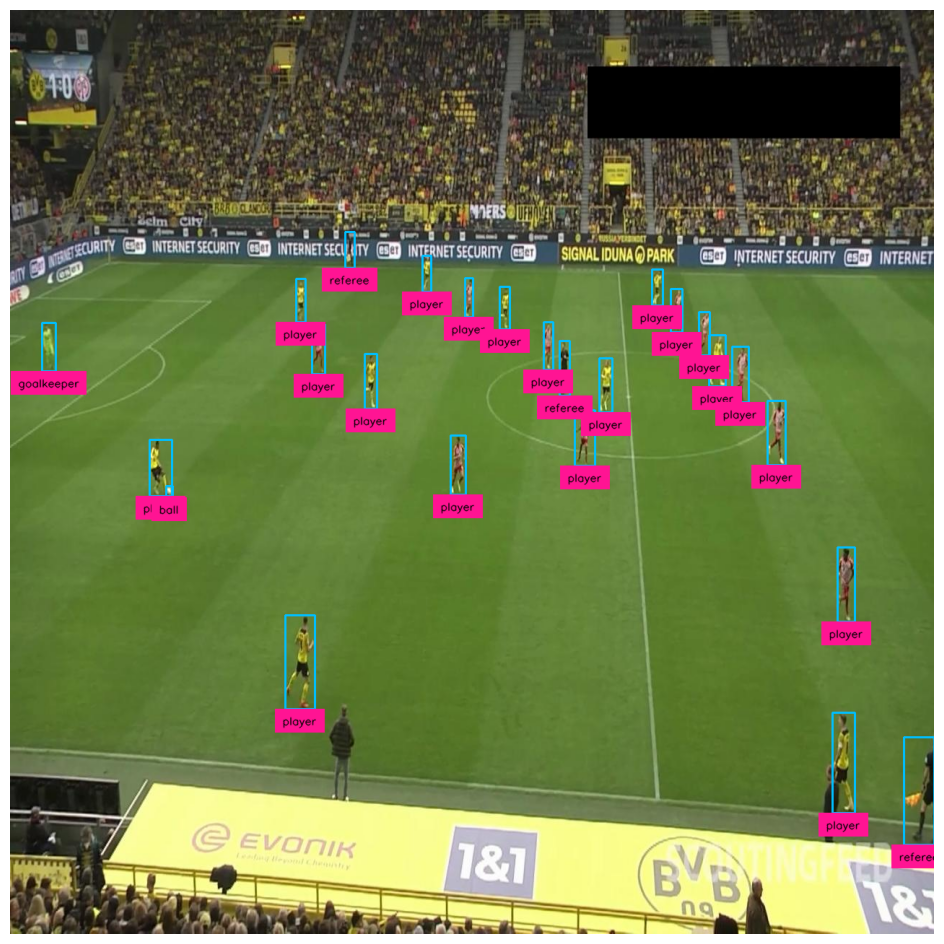

In [15]:
import json
import supervision as sv
import numpy as np
import cv2

# Load the COCO annotations JSON file
json_path = paths['DATA'] / 'coco_annotations' / 'test.json'
with open(json_path, 'r') as f:
    json_data = json.load(f)

# Retrieve image ID and file name from the JSON file
image_id, image_file_name, _, _ = json_data['images'][5].values()
print(f'Image id: {image_id}\nImage file name: {image_file_name}')

# Extract bounding boxes corresponding to the selected image ID
bboxes = [annotations['bbox'] for annotations in json_data['annotations'] if annotations['image_id'] == image_id]

# Map category IDs to category names
category_mapping = {category['id']: category['name'] for category in json_data['categories']}
categories_id = [category['category_id'] for category in json_data['annotations'] if category['image_id'] == image_id]
categories = [category_mapping[category['category_id']] for category in json_data['annotations'] if category['image_id'] == image_id]

# Create a Detections object with bounding box coordinates and category IDs
detections = sv.Detections(
    xyxy=np.array([[bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]] for bbox in bboxes]),
    class_id=np.array(categories_id)
)

# Load the corresponding image from the dataset
image_path = paths['DATA'] / 'images' / 'test' / image_file_name
image = cv2.imread(image_path)

# Create a BoxAnnotator object for drawing bounding boxes
box_annotator = sv.BoxAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2
)

# Create a LabelAnnotator object for adding category labels
label_annotator = sv.LabelAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

# Generate labels for detected objects
labels = [
    f"{category}"
    for category
    in categories
]

# Annotate the image with bounding boxes and labels
annotated_image = image.copy()
annotated_image = box_annotator.annotate(
    scene=annotated_image,
    detections=detections
)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

# Display the annotated image
sv.plot_image(annotated_image)
